## Tema 10: Numba. Cython. Ufuncs en Numba

Instalación de Numba en anaconda:

In [3]:
# Ejecutar en Google Colab
!pip install numpy matplotlib scikit-image numba cython setuptools


In [4]:
### EVITAR ERRORES

!uv pip install -q --system numba-cuda==0.4.0

from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1

In [5]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


TensorFlow version: 2.18.0
Num GPUs Available: 1


## A - Numba

__Python vs. modo object vs. modo nopython__

In [6]:
import numba as nb
import numpy as np

# Define a Python function that computes the sum of a list of numbers
def sum_vector(numbers):
    total = 0
    for num in numbers:
        total += num
    return total

# Decorate the function with the @jit decorator to enable Numba in object mode
@nb.jit
def sum_vector_numba(numbers):
    total = 0
    for num in numbers:
        total += num
    return total

# Decorate the function with the @jit decorator to enable Numba in nopython mode
@nb.jit(nopython=True)
def sum_vector_numba_nopython(numbers):
    total = 0
    for num in numbers:
        total += num
    return total

In [7]:
# Test the performance of the three functions
numbers = np.arange(1000000)
%timeit sum_vector(numbers)       # 100 loops, best of 5: 5.2 ms per loop
%timeit sum_vector_numba(numbers)  # 1000 loops, best of 5: 524 µs per loop
%timeit sum_vector_numba_nopython(numbers)  # 10000 loops, best of 5: 52.7 µs per loop

112 ms ± 49.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
438 µs ± 147 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
524 µs ± 98.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


__Compactación de un vector__

In [8]:
@nb.jit(nopython=True)
def nan_compact(x):
    out=np.empty_like(x)
    out_index = 0
    for element in x:
        if not np.isnan(element):
            out[out_index] = element
            out_index += 1
    return out[:out_index]

In [9]:
a = np.random.uniform(size=10000)
a[a<0.2] = np.nan
np.testing.assert_equal(nan_compact(a), a[~np.isnan(a)])

%timeit a[~np.isnan(a)]
%timeit nan_compact(a)

43.5 µs ± 278 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
11.1 µs ± 2.95 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


__Tiempo de compilación Numba__

In [10]:
from numba import jit
import numpy as np
import time

x = np.arange(100).reshape(10, 10)

@jit(nopython=True)
def go_fast(a): # Function is compiled and runs in machine code
    trace = 0.0
    for i in range(a.shape[0]):
        trace += np.tanh(a[i, i])
    return a + trace

# DO NOT REPORT THIS... COMPILATION TIME IS INCLUDED IN THE EXECUTION TIME!
start = time.time()
go_fast(x)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

# NOW THE FUNCTION IS COMPILED, RE-TIME IT EXECUTING FROM CACHE
start = time.time()
go_fast(x)
end = time.time()
print("Elapsed (after compilation) = %s" % (end - start))

Elapsed (with compilation) = 0.23360490798950195
Elapsed (after compilation) = 6.365776062011719e-05


__SumaDeRiemann_TODO.py__

In [11]:
import numpy as np
from numba import jit

def riemann_sum(n):
    dx = (np.pi/2 - 0) / n # Ancho de los intervalos
    riemann_sum = 0
    # TODO (bucle for)
    return riemann_sum

@jit
def riemann_sum_numba(n):
    dx = (np.pi/2 - 0) / n # Ancho de los intervalos
    riemann_sum = 0
    # TODO (bucle for)
    return riemann_sum

def riemann_sum_noloops(n):
    dx = (np.pi/2 - 0) / n # Ancho de los intervalos
    # TODO (sin bucles)
    return riemann_sum

@jit
def riemann_sum_noloops_numba(n):
    dx = (np.pi/2 - 0) / n # Ancho de los intervalos
    # TODO (sin bucles)
    return riemann_sum

# Comprobar con assert


## B - Cython

__Operaciones con vectores en Cython__

Código que implementa la suma de un número a los elementos de un vector en Cython (_cython_addvec.pyx_):

In [12]:
cimport numpy
import numpy as np

def cython_addvec(double [::1] vec, double value):
  """
  Adds a value to each element of a NumPy vector.

  Args:
      vec: A 1D NumPy array of doubles.
      value: The value to add to each element.

  Returns:
      A new NumPy array with the same shape as vec, where
      each element has been incremented by value.
  """

  cdef:
     int m = vec.shape[0]
     double[::1] result = np.zeros(m)

  for i in range(len(vec)):
    result[i] = vec[i] + value

  return result

SyntaxError: invalid syntax (<ipython-input-12-52f188e7e7f0>, line 1)

Script para generar los ficheros .c y .so a partir del .pyx (_setup.py_):

In [ ]:
from setuptools import setup
from Cython.Build import cythonize
import numpy

setup(
    ext_modules = cythonize("cython_addvec.pyx"),
    include_dirs=[numpy.get_include()]
)

Ejecutar:
```
$ python3 setup.py build_ext --inplace
```

Script que define una función en Python estándar y hace la comprobación (_test_addvec.py_):

In [ ]:
import numpy as np

num_elem = 10000

def python_addvec(vec, value):
  result = np.empty_like(vec)
  for i in range(len(vec)):
    result[i] = vec[i] + value
  return result

a=np.arange(num_elem, dtype=np.double)
x = 4.5
b_python = python_addvec(a, x)

# ---------------------------

from cython_addvec import cython_addvec
b_cython = cython_addvec(a, x)

np.testing.assert_array_equal(b_python, b_cython)

## C - Ufuncs en Numba

__Suma de vectores en GPU__

In [13]:
import numpy as np
from numba import vectorize

# Compila y optimiza una ufunc en la CPU
@vectorize
def add_cpu(x,y):
    return x+y

# Compila y optimiza una ufunc en la GPU
# Requiere signatura de tipos y target
@vectorize(['int64 (int64, int64)'], target='cuda')
def add_gpu(x,y):
    return x+y

In [14]:
a = np.arange(20)
b = np.arange(20)
%timeit add_cpu(a,b)
%timeit add_gpu(a,b)
%timeit np.add(a,b)

1.34 µs ± 247 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/dispatcher.py:605: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


855 µs ± 139 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
557 ns ± 58.6 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


__Ejemplo de ufunc: función gaussiana__

In [15]:
from numba import vectorize
import math # Para math.pi y math.exp
import numpy as np

SQRT_2PI = np.float32((2*math.pi)**0.5) # Precompute this
mean = np.float32(0.0)
sigma = np.float32(1.0)

# Versión python estándar
import scipy.stats
gaussian_pdf_python = scipy.stats.norm.pdf

# Versión NUMBA CPU
@vectorize
def gaussian_pdf_cpu(x, mean, sigma):
    return math.exp(-0.5 * ((x - mean) / sigma)**2) / (sigma * SQRT_2PI)

# Versión NUMBA GPU
@vectorize(['float32(float32, float32, float32)'], target='cuda')
def gaussian_pdf_gpu(x, mean, sigma):
    return math.exp(-0.5 * ((x - mean) / sigma)**2) / (sigma * SQRT_2PI)

In [16]:
x = np.random.uniform(-3, 3, size=1000000).astype(np.float32)
%timeit gaussian_pdf_python(x,mean,sigma)
%timeit gaussian_pdf_cpu(x,mean,sigma)
%timeit gaussian_pdf_gpu(x,mean,sigma)

39.3 ms ± 6.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
13.1 ms ± 1.83 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.02 ms ± 64 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


__Ejercicio 3: vectorizar función en la GPU__

In [17]:
from matplotlib import pyplot as plt
import numpy as np
from numba import vectorize

# TODO
def zero_suppress(waveform_value, threshold):
    if waveform_value < threshold:
        result = 0
    else:
        result = waveform_value
    return result

n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
noisy_signal = ((pulses * 300) + noise).astype(np.int16)

clean_signal = zero_suppress(noisy_signal, 15)

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
ax1.plot(noisy_signal)
ax1.set_ylabel("Señal ruidosa")
ax2.plot(clean_signal)
ax2.set_ylabel("Señal limpia")
fig.tight_layout()
fig.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

__Control de la memoria de la GPU__

In [18]:
from numba import vectorize, cuda
import numpy as np
n = 100000

@vectorize(['float32(float32, float32)'], target='cuda')
def add_ufunc(x, y):
    return x + y

x = np.arange(n).astype(np.float32)
y = 2 * x

# Movimiento explícito a GPU
d_x = cuda.to_device(x)
d_y = cuda.to_device(y)
z = add_ufunc(d_x, d_y)

# Almacena resultados en GPU
d_z = cuda.device_array(shape=(n,), dtype=np.float32)
add_ufunc(d_x, d_y, out=d_z)
h_z = d_z.copy_to_host()

/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/dispatcher.py:605: NumbaPerformanceWarning: Grid size 98 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [19]:
%timeit add_ufunc(x, y)
%timeit add_ufunc(d_x, d_y, out=d_z)

1.37 ms ± 149 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
197 µs ± 5.52 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


__Ejercicio 4: optimizar la gestión de la memoria__

/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/dispatcher.py:605: NumbaPerformanceWarning: Grid size 98 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/dispatcher.py:605: NumbaPerformanceWarning: Grid size 98 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


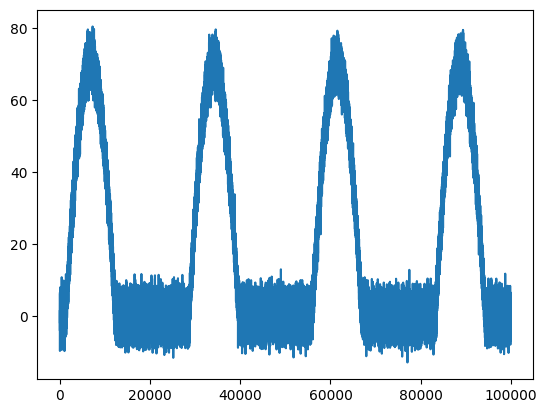

In [20]:
import math
from numba import vectorize, cuda
from matplotlib import pyplot as plt
import numpy as np

@vectorize(['float32(float32, float32, float32)'], target='cuda')
def make_pulses(i, period, amplitude):
    return max(math.sin(i / period) - 0.3, 0.0) * amplitude

@vectorize(['float32(float32, float32)'], target='cuda')
def add_ufunc(x, y):
    return x + y

n = 100000
period = n / 23
noise = (np.random.normal(size=n) * 3).astype(np.float32)
t = np.arange(n, dtype=np.float32)

pulses = make_pulses(t, period, 100.0).astype(np.float32)
waveform = add_ufunc(pulses, noise)

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(waveform)
fig.show()